# <center> Tweet Sentiment Analysis  </center> <br> 

### Estimation of the emotion of a tweet based on words of the tweet text and using an LSTM

### The dataset consists of 40,000 tweets with sentiments. 
### The sentiment is one of five (5) classes. The dataset features are:
- Tweet ID (ignore)
- Sentiment (categorical): tweet sentiment (target)
- Author (ignore)
- Content (string): text content of the tweet

License: Public domain (CC0)

Data: https://data.world/crowdflower/sentiment-analysis-in-text

In [1]:
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
import re
import string

from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import regularizers

from keras.models import Sequential
from keras.layers import Input, Embedding, LSTM, Dense, Activation, Dropout, BatchNormalization
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords 
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from livelossplot import PlotLossesKeras
from matplotlib import pyplot as plt

# 1. Read and clean the dataset

In [2]:
df = pd.read_csv("text_emotion.csv")
display(df.head(5))
display(df.info())
print("Number of NaNs:", np.sum(df.isnull().any(axis=1)))

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   author     40000 non-null  object
 3   content    40000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


None

Number of NaNs: 0


## Get number of classes

['anger' 'boredom' 'empty' 'enthusiasm' 'fun' 'happiness' 'hate' 'love'
 'neutral' 'relief' 'sadness' 'surprise' 'worry']
13


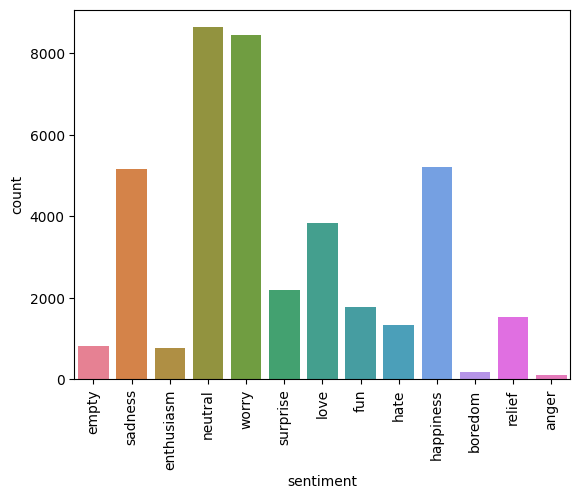

In [3]:
classes = np.unique(df["sentiment"])
nr_classes = len(classes)
print(classes)
print(nr_classes)
sns.countplot(x ='sentiment', data = df, hue='sentiment')
plt.xticks(rotation = 90);

## Group the sentiments into tw classes, positive, negative, neutral

In [4]:
positive_sel = df.sentiment.str.contains('enthusiasm|fun|happiness|love|surprise|relief', case=False, regex=True)
nr_pos_tweets = np.sum(positive_sel)
print(nr_pos_tweets)

negative_sel = df.sentiment.str.contains('anger|boredom|empty|hate|sadness|worry', case=False, regex=True)
nr_neg_tweets = np.sum(negative_sel)
print(nr_neg_tweets)

neutral_sel = df.sentiment.str.contains('neutral', case=False, regex=True)
nr_neut_tweets = np.sum(neutral_sel)
print(nr_neut_tweets)

print(nr_pos_tweets+nr_neg_tweets+nr_neut_tweets)

15299
16063
8638
40000


In [5]:
df.loc[positive_sel,'sentiment'] = 'positive'
df.loc[negative_sel,'sentiment'] = 'negative'
df.loc[neutral_sel,'sentiment'] = 'neutral'

['negative' 'neutral' 'positive']
3


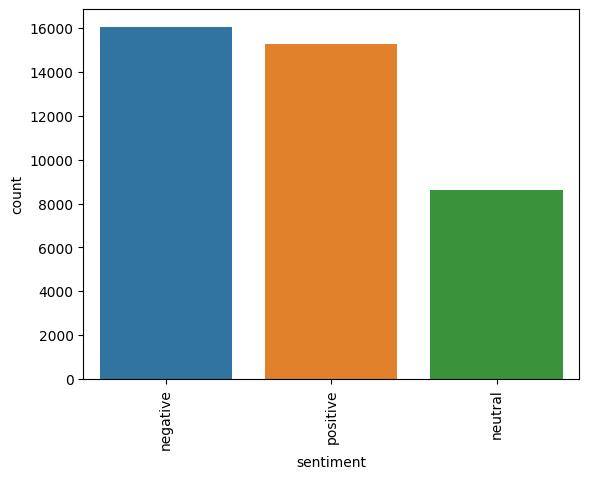

In [6]:
classes = np.unique(df["sentiment"])
nr_classes = len(classes)
print(classes)
print(nr_classes)
sns.countplot(x ='sentiment', data = df, hue='sentiment')
plt.xticks(rotation = 90);

## Encode the sentiments column

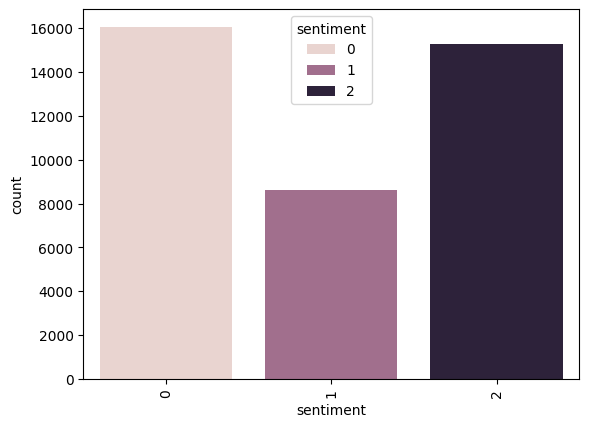

In [7]:
sentiment_encoder = LabelEncoder()
df.sentiment = sentiment_encoder.fit_transform(df.sentiment)
sns.countplot(x ='sentiment', data = df, hue='sentiment')
plt.xticks(rotation = 90);

In [8]:
decoded_labels = {0:'',1:'',2:''}
decoded_labels[0] = sentiment_encoder.inverse_transform([0])[0]
decoded_labels[1] = sentiment_encoder.inverse_transform([1])[0]
decoded_labels[2] = sentiment_encoder.inverse_transform([2])[0]
print(decoded_labels)

{0: 'negative', 1: 'neutral', 2: 'positive'}


# 2. Process the text in the tweets
- Convert text to lowercase
- Remove stopwords
- Removing special characters (emojis, hashtags, etc.)
- Remove punctuations
- Remove repeating characters
- Remove URLs 
- Perform Stemming on the text (reduce words to their stems)
- Perform Lemmatization on the text(reducing words to their root form aka lemma)

## Explore tweets' contents

In [9]:
idx = 0
print(df['content'][idx])
print(df['sentiment'][idx])

@tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[
0


In [10]:
STOPWORDS = stopwords.words('english')
PUNCTUATIONS = string.punctuation

def clean_tweet(text):

    # Convert text to lowercase
    new_txt = text.lower()

    # Remove stopwords
    new_txt=" ".join([word for word in str(new_txt).split() if word not in STOPWORDS])

    # Remove words with length < 3
    #new_txt=" ".join([word for word in str(new_txt).split() if len(word)>3])

    # Remove punctuations
    translator = str.maketrans('', '', PUNCTUATIONS)
    new_txt= new_txt.translate(translator)

    # Remove repeating characters
    new_txt = re.sub(r'(.)1+', r'1', new_txt)

    # Remove URLs
    new_txt = re.sub('((www.[^s]+)|(https?://[^s]+))',' ',new_txt)

    # Remove numbers
    new_txt = re.sub('[0-9]+', '', new_txt)

    # Word tokenize the text
    word_tokens = text_to_word_sequence(new_txt)

    # Get Stemm from each word
    # For example, “Drove” and “Driving” should both be reduced to their stem “Drive”
    st = nltk.PorterStemmer()
    word_tokens = [st.stem(w) for w in word_tokens]

    # Get lemma from each word
    # Lemmatization uses the context of words to convert them into a common form. 
    # For example, lemmatisation should convert “is”, “are” and “being” all into “be”
    #lm = nltk.WordNetLemmatizer()
    #word_tokens = [lm.lemmatize(w) for w in word_tokens]

    # Keep onl adjectived and nouns
    #word_tokens = [w for w,tag in nltk.pos_tag(word_tokens) if ((tag[0] in "JJ") or (tag[0] in "NN"))]
    
    return word_tokens

df['content'] = df['content'].apply(clean_tweet)
df['content'].head()

0    [tiffanylu, know, listenin, bad, habit, earlie...
1         [layin, n, bed, headach, ughhhhwaitin, call]
2                      [funer, ceremonygloomi, friday]
3                           [want, hang, friend, soon]
4    [dannycastillo, want, trade, someon, houston, ...
Name: content, dtype: object

# Explore tweets after processing them

In [11]:
idx = 0
print(df['content'][idx])
print(decoded_labels[df['sentiment'][idx]])

['tiffanylu', 'know', 'listenin', 'bad', 'habit', 'earlier', 'start', 'freakin', 'part']
negative


# Generate a vocabulary from all tweets

In [12]:
# Create a list with all tweets
tweets_ls = df['content'].to_numpy()

all_tweeted_words = [word for words_ls in tweets_ls for word in words_ls]

print("Nr. of tweets; ", np.shape(tweets_ls))
print("Nr. of total words; ", len(all_tweeted_words))
print(tweets_ls[0])
print(all_tweeted_words[0])

Nr. of tweets;  (40000,)
Nr. of total words;  313953
['tiffanylu', 'know', 'listenin', 'bad', 'habit', 'earlier', 'start', 'freakin', 'part']
tiffanylu


In [13]:
print("Total Nr. Words:", np.shape(all_tweeted_words))
print("Vocabulary Size:", len(np.unique(all_tweeted_words)))

Total Nr. Words: (313953,)
Vocabulary Size: 45366


In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_tweeted_words)
tokens = tokenizer.word_index

In [15]:
print(len(np.unique(all_tweeted_words)))
print(len(tokenizer.word_index))

45366
45366


# Get the Vocabulary Size

In [16]:
vocabulary_size = len(tokenizer.word_index)
print(vocabulary_size)

45366


# Build sequences of tokens

In [17]:
# Verify max_tweet_length
max_tweet_length= df["content"].str.len().max()
print(max_tweet_length)

max_tweet_length_2 = max([len(tweet_txt) for tweet_txt in tweets_ls])
print(max_tweet_length_2)

26
26


In [18]:
# build subsequences of different sizes, starting from 1 to the size of the sequence. 
sequences = tokenizer.texts_to_sequences(tweets_ls)
sequences = pad_sequences(sequences, maxlen=max_tweet_length, padding='pre')

In [19]:
print(sequences.shape)
print(sequences[0])

(40000, 26)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0 12231    16  2742    65  3483   707    86
  1020   382]


# Build Input and Output
#### The input to the network is all the words of the sequence except the last one, and the output is the last word of the sequence.
#### Then, convert output into categorical data using the to_categorical() method from the keras.utils module.

In [20]:
nr_classes

3

In [21]:
X = sequences
y = df[["sentiment"]].to_numpy().ravel()
print(np.unique(y))

[0 1 2]


In [22]:
print(X.shape)
print(y.shape)

(40000, 26)
(40000,)


In [23]:
X[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0, 12231,
          16,  2742,    65,  3483,   707,    86,  1020,   382])

In [24]:
y[0]

0

# Build training, validationand test sets

In [25]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=0)

In [26]:
print(X_train.shape)
print(y_train.shape)

print(X_valid.shape)
print(y_valid.shape)

print(X_test.shape)
print(y_test.shape)

(25600, 26)
(25600,)
(6400, 26)
(6400,)
(8000, 26)
(8000,)


# Train an ANN to perform NLP

In [27]:

# Define architecture
model=Sequential()
#model.add(Input(shape=(max_tweet_length,)))

model.add(Embedding(input_dim=vocabulary_size+1, 
                    output_dim=5,
                    input_length=max_tweet_length,
                     embeddings_regularizer=regularizers.L2(0.01),
                     embeddings_constraint=None))

model.add(LSTM(100, kernel_regularizer=regularizers.L2(0.01),recurrent_regularizer=regularizers.L2(1)))
# #model.add(LSTM(200))
#model.add(BatchNormalization())
model.add(Dropout(0.2))

# # Hidden layer
# model.add(Dense(units=20, 
#                 activation='relu', 
#                 kernel_initializer='uniform', 
#                 kernel_regularizer=regularizers.L2(0.1), 
#                 bias_regularizer=regularizers.L2(0.1), 
#                 activity_regularizer=regularizers.L2(0.1)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

model.add(Dense(units=nr_classes, activation='softmax'))


# Compile NN
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 26, 5)             226835    
                                                                 
 lstm (LSTM)                 (None, 100)               42400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 269538 (1.03 MB)
Trainable params: 269538 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


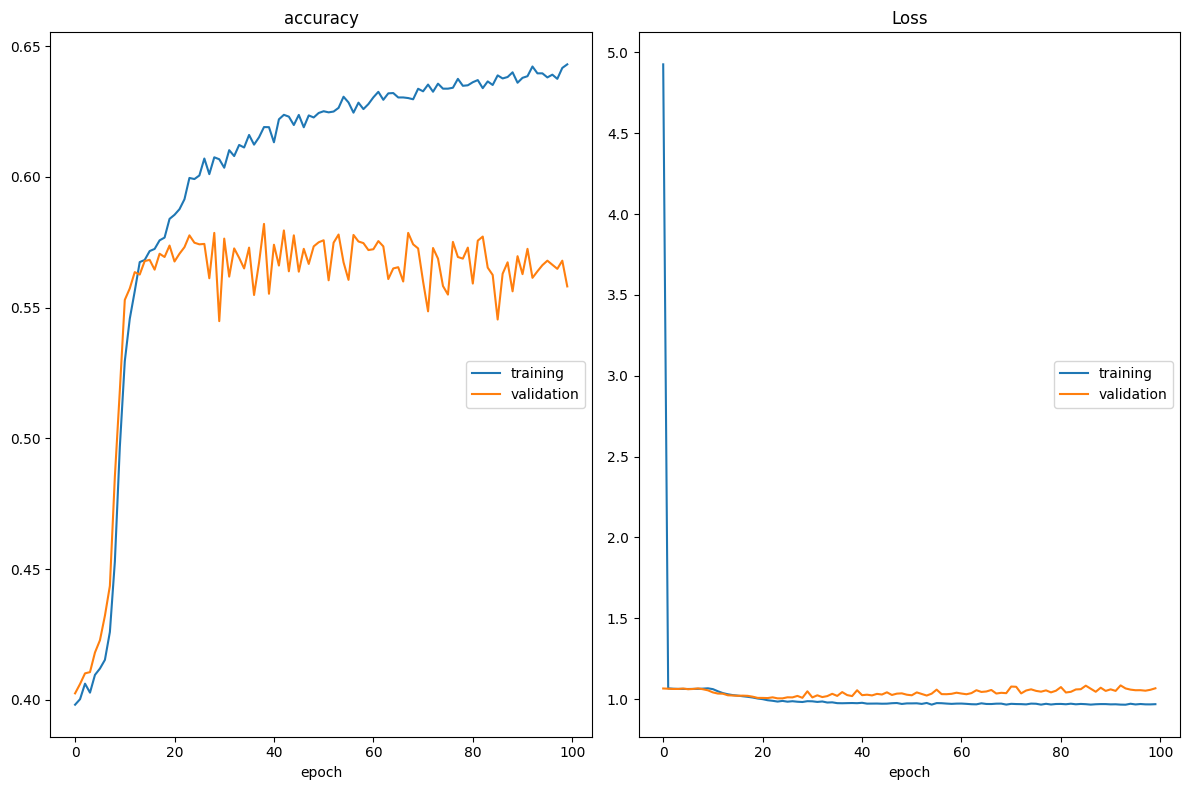

accuracy
	training         	 (min:    0.398, max:    0.643, cur:    0.643)
	validation       	 (min:    0.403, max:    0.582, cur:    0.558)
Loss
	training         	 (min:    0.965, max:    4.926, cur:    0.969)
	validation       	 (min:    1.005, max:    1.085, cur:    1.067)
800/800 [==============================] - 11s 14ms/step - loss: 0.9686 - accuracy: 0.6430 - val_loss: 1.0670 - val_accuracy: 0.5581


In [28]:
# Train NN
history = model.fit(X_train, y_train, 
                    batch_size=32, 
                    epochs=100, 
                    validation_data=(X_valid, y_valid), 
                    callbacks=[PlotLossesKeras()],
                    verbose=1)

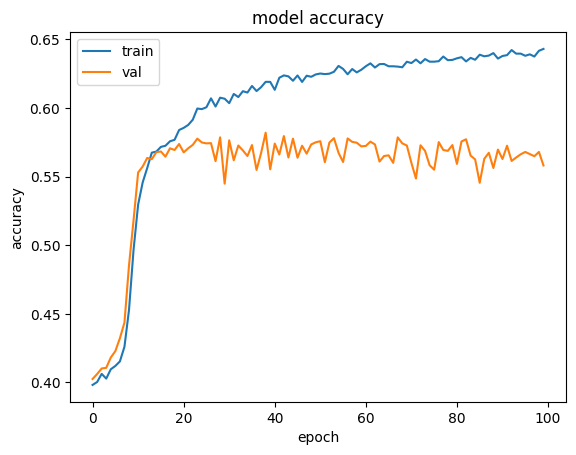

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

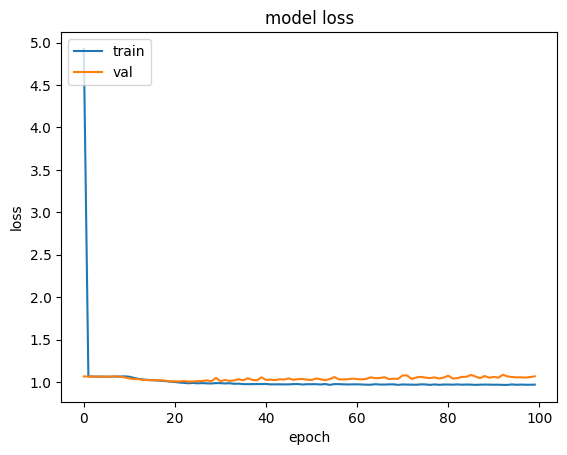

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluate model

In [31]:
model.evaluate(X_test, y_test)

250/250 [==============================] - 2s 6ms/step - loss: 1.0733 - accuracy: 0.5656


[1.073323369026184, 0.565625011920929]